Team Members:
Jetendra Mulinti, Goutham Vemula, Prajeeth Nakka

Introduction: We are creating 2 ML models (Decision Trees and Random forest) & pick one ML model which predicts the reg_pct_level.
Steps we are following

1. Loading data
2. Cleaning data
3. EDA
4. Feature selection
5. Train the model with 2 Models
6. Validating Metrics.
7. Selecting Models
8. Conclusion

In [1]:
### Import packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os
from datetime import datetime

### sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

###### Standardization of the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#### Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_poisson_deviance, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import glm

from sklearn.metrics import mean_squared_error

# Data Loading

In [2]:
github_url = 'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/M11%20Practical%20Challenge%20Decision%20Tree%20versus%20Random%20Forest%20Performance/M11_Data.csv'

NY_df = pd.read_csv(github_url)
NY_df.head(2)

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%


# Data Cleaning

In [3]:
#### upon oberserving the data in excel we found some rows are having '-' so planning to remove them

print("No of rows with -'s instead of data: ",len(NY_df[NY_df['enroll_cnt'] == '-']))
print(" % of missing data: ",len(NY_df[NY_df['enroll_cnt'] == '-']) / len(NY_df) * 100)

##### removing that data
NY_df = NY_df[NY_df['enroll_cnt'] != '-'].reset_index(drop=True)

print("Post cleaning of data: ",len(NY_df))

No of rows with -'s instead of data:  33478
 % of missing data:  45.76498250218723
Post cleaning of data:  39674


In [4]:
print("Shape of the data: ", NY_df.shape)

Shape of the data:  (39674, 19)


In [5]:
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39674 entries, 0 to 39673
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   report_school_year  39674 non-null  object
 1   aggregation_index   39674 non-null  int64 
 2   aggregation_type    39674 non-null  object
 3   aggregation_name    39674 non-null  object
 4   nrc_code            39674 non-null  int64 
 5   nrc_desc            39674 non-null  object
 6   county_code         39674 non-null  int64 
 7   county_name         39674 non-null  object
 8   nyc_ind             39674 non-null  int64 
 9   membership_desc     39674 non-null  object
 10  subgroup_code       39674 non-null  int64 
 11  subgroup_name       39674 non-null  object
 12  enroll_cnt          39674 non-null  object
 13  grad_cnt            39674 non-null  object
 14  grad_pct            39674 non-null  object
 15  reg_cnt             39674 non-null  object
 16  reg_pct             39

In [6]:
####### Converting Data Types as per data

def convert_column_data_types(df):
    
    # Convert 'cnt' columns to int and 'pct' columns to float before that remove % symbol
    for column in df.columns:
        if column.endswith('cnt'):
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(int)
        elif column.endswith('pct'):
            df[column] = df[column].str.replace('%', '').astype(float)
    
    # Convert specific columns based on the suggested data types
    specific_columns = {
        'report_school_year': 'object',
        'aggregation_index': 'int64',
        'aggregation_type': 'object',
        'nrc_code': 'int64',
        'nrc_desc': 'object',
        'county_code': 'int64',
        'county_name': 'object',
        'nyc_ind': 'bool',
        'membership_desc': 'object',
        'subgroup_code': 'int64',
        'subgroup_name': 'object'
    }
    
    for column, dtype in specific_columns.items():
        if column in df.columns:
            if dtype == 'bool':
                df[column] = df[column].astype(bool)
            else:
                df[column] = df[column].astype(dtype)
    
    return df

In [7]:
### Calling functions to change the data types

NY_df =convert_column_data_types(NY_df)

NY_df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71.0,310,47.0,148,22.0
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76.0,169,52.0,65,20.0
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65.0,141,42.0,83,25.0
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68.0,183,50.0,91,25.0
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,58,59.0,40,41.0,28,29.0


In [9]:
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39674 entries, 0 to 39673
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_school_year  39674 non-null  object 
 1   aggregation_index   39674 non-null  int64  
 2   aggregation_type    39674 non-null  object 
 3   aggregation_name    39674 non-null  object 
 4   nrc_code            39674 non-null  int64  
 5   nrc_desc            39674 non-null  object 
 6   county_code         39674 non-null  int64  
 7   county_name         39674 non-null  object 
 8   nyc_ind             39674 non-null  bool   
 9   membership_desc     39674 non-null  object 
 10  subgroup_code       39674 non-null  int64  
 11  subgroup_name       39674 non-null  object 
 12  enroll_cnt          39674 non-null  int32  
 13  grad_cnt            39674 non-null  int32  
 14  grad_pct            39674 non-null  float64
 15  reg_cnt             39674 non-null  int32  
 16  reg_

# EDA

In [10]:
## Sitation: Help from chatgpt
###### Creating a function that gives univariate analysis on quantitative columns


def Hist_BoxPlotFunction(df, pdf_filename):

    # Path for saving the PDF in the current working directory
    pdf_path = os.path.join(os.getcwd(), pdf_filename)
    
    quantitative_columns = df.select_dtypes(include=['float64', 'int64','int32']).columns
    
    with PdfPages(pdf_path) as pdf:
        for col in quantitative_columns:
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            
            # Histogram
            sns.histplot(df[col], ax=axs[0], kde=True)
            axs[0].set_title(f'Histogram of {col}')
            
            # Box Plot
            sns.boxplot(x=df[col], ax=axs[1])
            axs[1].set_title(f'Box Plot of {col}')
            
            plt.tight_layout()
            pdf.savefig(fig)  # Save the figure into the PDF
            plt.show()  # Display the plot
            plt.close(fig)  # Close to free up memory

StopIteration: 

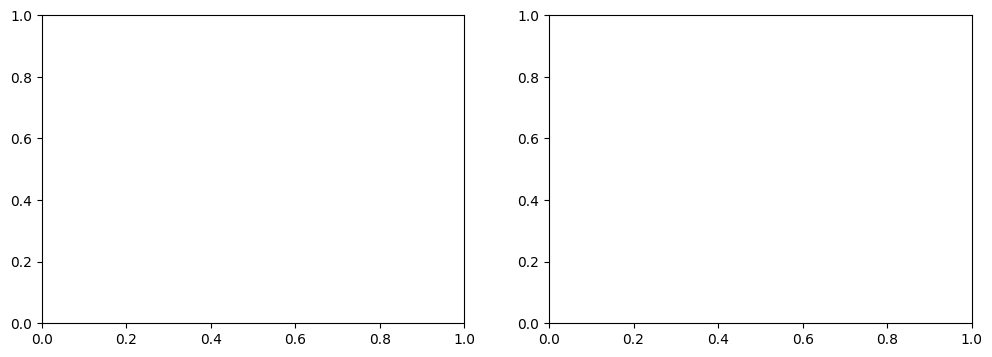

In [11]:
Hist_BoxPlotFunction(NY_df,'Quant_visuals.pdf')

# Observations
1. Distribution shapes vary, with right-skewness in enrollment and graduation counts, indicating many small values and fewer large values.
2. County and subgroup codes show multi-modal distributions, suggesting diverse representation across multiple categories.
3. Graduation-related percentages are left-skewed, most schools have high success rates, while dropout rates are low but varied.
4. Outliers are present in most distributions, indicating extreme values that could be special cases or data entry errors.
5. The data might require transformation for certain statistical analyses or predictive modeling due to skewness and outliers.